In [19]:
import os
import time

import autokeras as ak
import kerastuner
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    classification_report,
    confusion_matrix
)
from tensorflow.keras.models import load_model


In [20]:
def plot_accuracy_graph(training_accuracies, val_accuracies):
    epochs = range(1, len(training_accuracies) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()  


def plot_loss_graph(training_losses, val_losses):
    epochs = range(1, len(training_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-x', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  


def plot_confusion_matrix(y_true, y_pred, class_names=None, title="Confusion Matrix"):

    cm = confusion_matrix(y_true, y_pred)

    if class_names is None:
        unique_labels = sorted(set(list(y_true) + list(y_pred)))
        class_names = [str(label) for label in unique_labels]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()  


In [24]:
def train(data_flag, x_train, y_train, x_val, y_val, num_trials):
    # Initializing the AutoKeras classifier
    clf = ak.ImageClassifier(
        multi_label=False, 
        project_name=data_flag,
        distribution_strategy=tf.distribute.MirroredStrategy(),
        metrics=['AUC', 'accuracy'],
        objective=kerastuner.Objective("val_auc", direction="max"),
        overwrite=True,
        max_trials=num_trials
    )

    # Train the model and save the training process
    history = clf.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=5
    )

    # Get the training/validation accuracy and loss from history
    training_accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    training_losses = history.history['loss']
    val_losses = history.history['val_loss']

    # Only the final (entire training process) Accuracy & Loss curves are displayed in the Notebook
    plot_accuracy_graph(training_accuracies, val_accuracies)
    plot_loss_graph(training_losses, val_losses)

    model = clf.export_model()

    try:
        model.save(f'{data_flag}_autokeras', save_format="tf")
    except Exception:
        model.save(f'{data_flag}_autokeras.h5')

    return model


def test(model, x, y_true, split):
    # Model predictions
    y_score = model.predict(x)
    print(f"y_score shape: {y_score.shape}")
    print(f"y_true shape: {y_true.shape}")

    # If the output is multi-dimensional, squeeze the predictions
    # This facilitates binary classification decisions or multi-class argmax
    if len(y_score.shape) > 1:
        y_score = y_score.squeeze()

    # Confusion Matrix & Classification Report
    # Determine whether it is binary classification based on the shape of the data
    if (len(y_true.shape) == 1) or (y_true.shape[1] == 1):
        # Binary classification task
        y_true = y_true.flatten()
        auc = roc_auc_score(y_true, y_score)
        acc = accuracy_score(y_true, (y_score > 0.5).astype(int))

        # Obtain binary classification prediction labels
        y_pred = (y_score > 0.5).astype(int)

        # Print classification report
        report = classification_report(y_true, y_pred, digits=4)
        print(f"\nClassification Report ({split} set):\n{report}\n")

        # Plot confusion matrix
        plot_confusion_matrix(
            y_true, y_pred, 
            class_names=['0', '1'], 
            title=f"{split.capitalize()} Confusion Matrix"
        )

    else:
        # Multi-class classification task
        y_true_classes = np.argmax(y_true, axis=1)
        y_score_multi = model.predict(x)  # Do not squeeze y_score
        y_pred_classes = np.argmax(y_score_multi, axis=1)

        auc = roc_auc_score(y_true, y_score_multi, multi_class='ovo')
        acc = accuracy_score(y_true_classes, y_pred_classes)

        # Print classification report
        report = classification_report(y_true_classes, y_pred_classes, digits=4)
        print(f"\nClassification Report ({split} set):\n{report}\n")

        # Plot confusion matrix
        plot_confusion_matrix(
            y_true_classes, y_pred_classes, 
            class_names=None, 
            title=f"{split.capitalize()} Confusion Matrix"
        )

    # Print AUC and Accuracy at the end
    print(f"{split}  AUC: {auc:.5f}, Accuracy: {acc:.5f}\n")


def main(data_flag, num_trials, input_root, run, model_path):
    # (Set GPU if necessary)
    # os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    # os.environ["CUDA_VISIBLE_DEVICES"] = "1"

    # Load custom .npz data file
    # Modify the example path below as needed
    data_path = input_root
    data = np.load(data_path)

    x_train, y_train = data['train_images'], data['train_labels']
    x_val, y_val = data['val_images'], data['val_labels']
    x_test, y_test = data['test_images'], data['test_labels']

    # Print dataset shapes
    print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
    print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
    print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

    # Test the pre-trained model if provided
    if model_path is not None:
        model = load_model(model_path, custom_objects=ak.CUSTOM_OBJECTS)
        test(model, x_train, y_train, 'train')
        test(model, x_val, y_val, 'val')
        test(model, x_test, y_test, 'test')

    # If num_trials=0, skip training and exit
    if num_trials == 0:
        return

    # Train the model
    model = train(data_flag, x_train, y_train, x_val, y_val, num_trials)

    # Test the trained model
    test(model, x_train, y_train, 'train')
    test(model, x_val, y_val, 'val')
    test(model, x_test, y_test, 'test')


# Origin data

Trial 1 Complete [00h 00m 08s]
val_auc: 0.9948776960372925

Best val_auc So Far: 0.9948776960372925
Total elapsed time: 00h 00m 08s
Epoch 1/5


2025-01-09 18:36:43.200808: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 4708
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1380"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR

144/148 [============================>.] - ETA: 0s - loss: 0.2229 - auc: 0.9571 - accuracy: 0.9112

2025-01-09 18:36:44.957934: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 524
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1385"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR


148/148 [==============================] - 2s 10ms/step - loss: 0.2222 - auc: 0.9574 - accuracy: 0.9119 - val_loss: 0.1226 - val_auc: 0.9883 - val_accuracy: 0.9561
Epoch 2/5
148/148 [==============================] - 1s 9ms/step - loss: 0.1404 - auc: 0.9832 - accuracy: 0.9494 - val_loss: 0.1075 - val_auc: 0.9927 - val_accuracy: 0.9656
Epoch 3/5
148/148 [==============================] - 1s 9ms/step - loss: 0.1277 - auc: 0.9859 - accuracy: 0.9520 - val_loss: 0.0954 - val_auc: 0.9942 - val_accuracy: 0.9580
Epoch 4/5
148/148 [==============================] - 1s 9ms/step - loss: 0.1168 - auc: 0.9879 - accuracy: 0.9588 - val_loss: 0.0949 - val_auc: 0.9938 - val_accuracy: 0.9561
Epoch 5/5
148/148 [==============================] - 1s 9ms/step - loss: 0.1014 - auc: 0.9903 - accuracy: 0.9639 - val_loss: 0.0853 - val_auc: 0.9949 - val_accuracy: 0.9542
INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


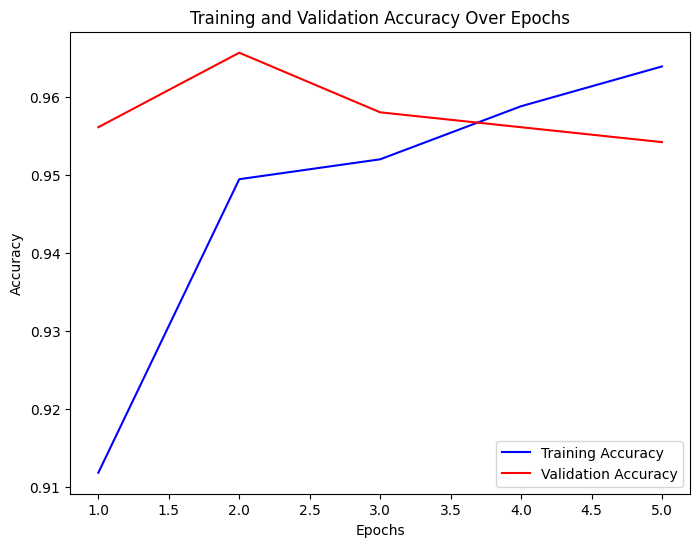

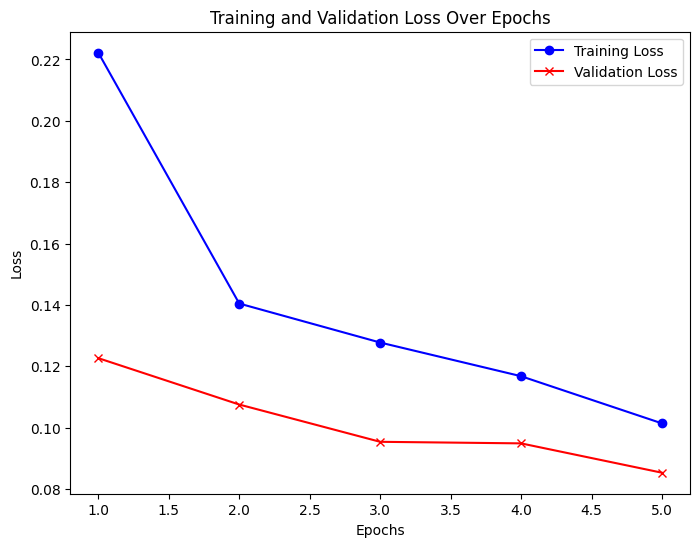

INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


148/148 [==============================] - 0s 3ms/step
y_score shape: (4708, 1)
y_true shape: (4708, 1)

Classification Report (train set):
              precision    recall  f1-score   support

           0     0.9587    0.9374    0.9479      1214
           1     0.9784    0.9860    0.9822      3494

    accuracy                         0.9734      4708
   macro avg     0.9686    0.9617    0.9651      4708
weighted avg     0.9733    0.9734    0.9734      4708




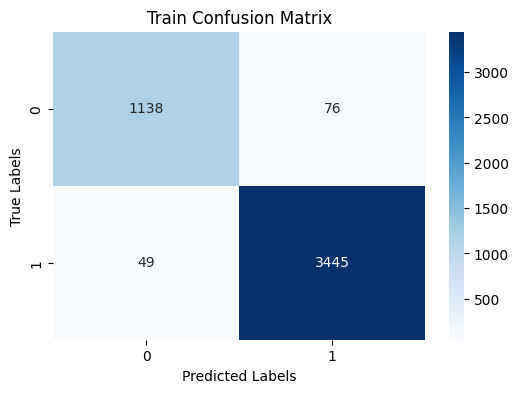

train  AUC: 0.99528, Accuracy: 0.97345

17/17 [==============================] - 0s 3ms/step
y_score shape: (524, 1)
y_true shape: (524, 1)

Classification Report (val set):
              precision    recall  f1-score   support

           0     0.9370    0.8815    0.9084       135
           1     0.9597    0.9794    0.9695       389

    accuracy                         0.9542       524
   macro avg     0.9484    0.9305    0.9389       524
weighted avg     0.9539    0.9542    0.9537       524




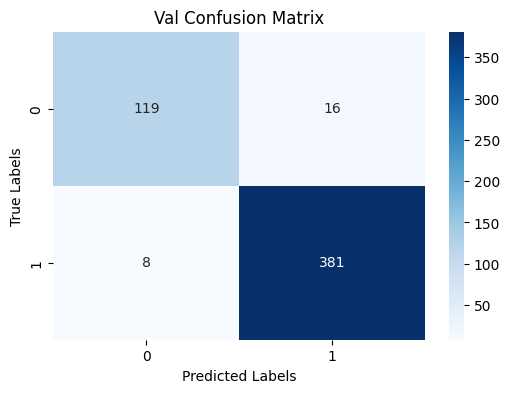

val  AUC: 0.99495, Accuracy: 0.95420

20/20 [==============================] - 0s 4ms/step
y_score shape: (624, 1)
y_true shape: (624, 1)

Classification Report (test set):
              precision    recall  f1-score   support

           0     0.9866    0.6282    0.7676       234
           1     0.8168    0.9949    0.8971       390

    accuracy                         0.8574       624
   macro avg     0.9017    0.8115    0.8324       624
weighted avg     0.8805    0.8574    0.8486       624




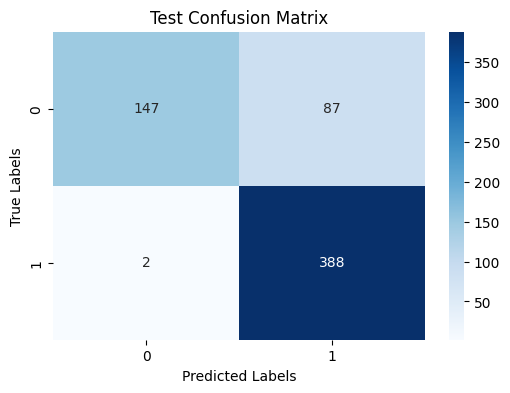

test  AUC: 0.93192, Accuracy: 0.85737



In [ ]:

data_flag = 'pathmnist'
input_root = '/home/wsl/classwork/7015/ass1/pneumoniamnist.npz'
run = 'model1'
model_path = None  
num_trials = 1     

main(data_flag, num_trials, input_root, run, model_path)


# DCGAN

Trial 2 Complete [00h 28m 47s]
val_auc: 0.9857945442199707

Best val_auc So Far: 0.9941160678863525
Total elapsed time: 00h 28m 58s
Epoch 1/5


2025-01-09 18:34:35.677413: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 6988
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:910"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR


217/219 [============================>.] - ETA: 0s - loss: 0.1760 - auc: 0.9819 - accuracy: 0.9294

2025-01-09 18:34:38.220049: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 524
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:915"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
 

219/219 [==============================] - 3s 10ms/step - loss: 0.1755 - auc: 0.9820 - accuracy: 0.9296 - val_loss: 0.1162 - val_auc: 0.9909 - val_accuracy: 0.9523
Epoch 2/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0950 - auc: 0.9941 - accuracy: 0.9644 - val_loss: 0.1094 - val_auc: 0.9936 - val_accuracy: 0.9542
Epoch 3/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0791 - auc: 0.9957 - accuracy: 0.9710 - val_loss: 0.1059 - val_auc: 0.9934 - val_accuracy: 0.9561
Epoch 4/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0714 - auc: 0.9964 - accuracy: 0.9732 - val_loss: 0.1141 - val_auc: 0.9934 - val_accuracy: 0.9656
Epoch 5/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0674 - auc: 0.9965 - accuracy: 0.9752 - val_loss: 0.0971 - val_auc: 0.9935 - val_accuracy: 0.9580
INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


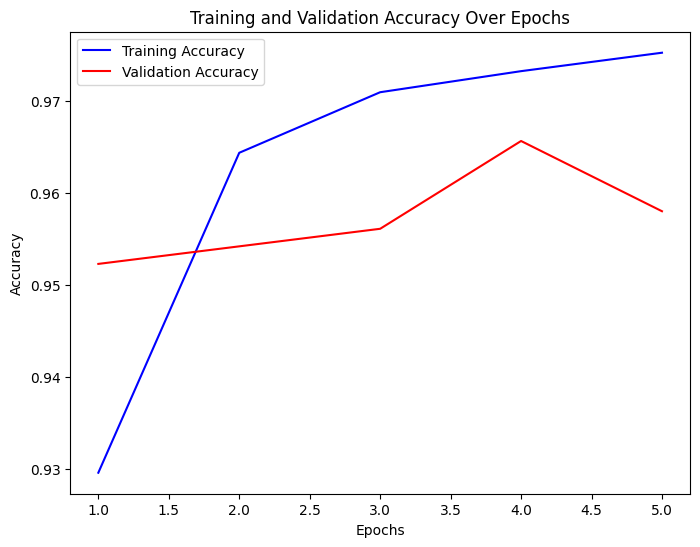

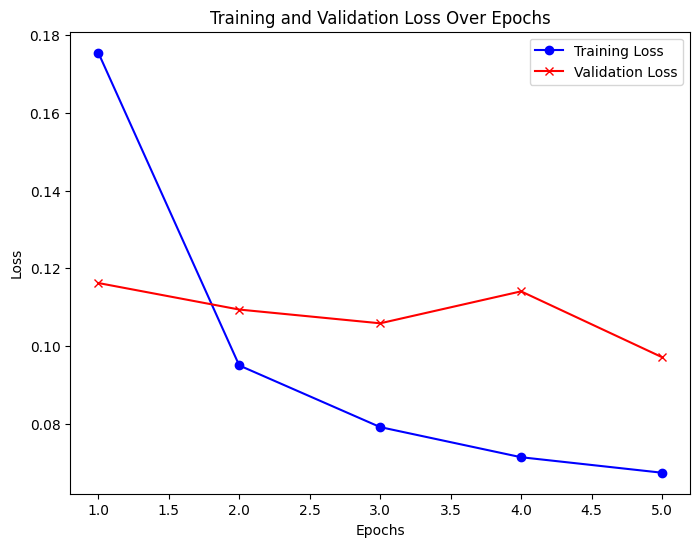

INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


219/219 [==============================] - 1s 3ms/step
y_score shape: (6988, 1)
y_true shape: (6988, 1)

Classification Report (train set):
              precision    recall  f1-score   support

           0     0.9823    0.9831    0.9827      3494
           1     0.9831    0.9823    0.9827      3494

    accuracy                         0.9827      6988
   macro avg     0.9827    0.9827    0.9827      6988
weighted avg     0.9827    0.9827    0.9827      6988




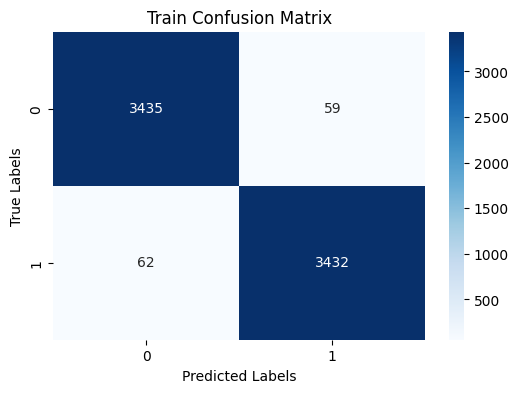

train  AUC: 0.99867, Accuracy: 0.98268

17/17 [==============================] - 0s 2ms/step
y_score shape: (524, 1)
y_true shape: (524, 1)

Classification Report (val set):
              precision    recall  f1-score   support

           0     0.9065    0.9333    0.9197       135
           1     0.9766    0.9666    0.9716       389

    accuracy                         0.9580       524
   macro avg     0.9415    0.9500    0.9456       524
weighted avg     0.9586    0.9580    0.9582       524




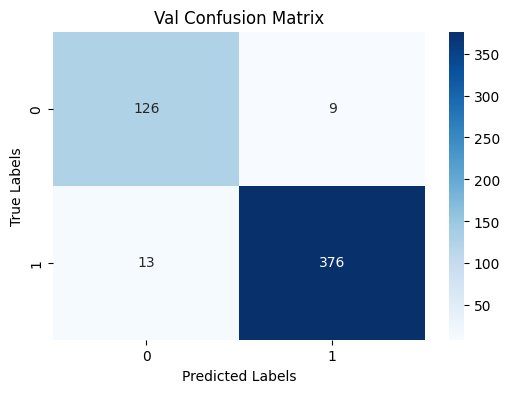

val  AUC: 0.99366, Accuracy: 0.95802

20/20 [==============================] - 0s 3ms/step
y_score shape: (624, 1)
y_true shape: (624, 1)

Classification Report (test set):
              precision    recall  f1-score   support

           0     0.9758    0.6880    0.8070       234
           1     0.8410    0.9897    0.9093       390

    accuracy                         0.8766       624
   macro avg     0.9084    0.8389    0.8582       624
weighted avg     0.8915    0.8766    0.8709       624




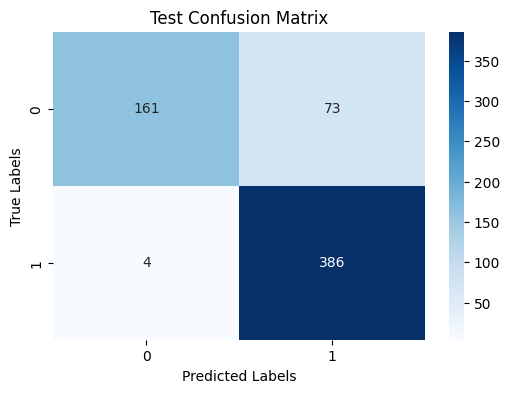

test  AUC: 0.93573, Accuracy: 0.87660



In [25]:

data_flag = 'pathmnist'
input_root = '/home/wsl/classwork/7015/ass1/MedMNIST/examples/DCGAN_DATA/Merge_DCGAN_data1.npz'
run = 'model1'
model_path = None  
num_trials = 2    

main(data_flag, num_trials, input_root, run, model_path)


# ACGAN

Trial 2 Complete [00h 28m 45s]
val_auc: 0.9515947699546814

Best val_auc So Far: 0.9922308325767517
Total elapsed time: 00h 28m 56s
Epoch 1/5


2025-01-09 19:07:08.112749: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 6988
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1941"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR

217/219 [============================>.] - ETA: 0s - loss: 0.1957 - auc: 0.9773 - accuracy: 0.9188

2025-01-09 19:07:10.766566: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 524
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:1946"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR


219/219 [==============================] - 3s 10ms/step - loss: 0.1949 - auc: 0.9775 - accuracy: 0.9191 - val_loss: 0.2565 - val_auc: 0.9844 - val_accuracy: 0.8912
Epoch 2/5
219/219 [==============================] - 3s 15ms/step - loss: 0.0979 - auc: 0.9934 - accuracy: 0.9644 - val_loss: 0.2276 - val_auc: 0.9867 - val_accuracy: 0.8989
Epoch 3/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0853 - auc: 0.9949 - accuracy: 0.9698 - val_loss: 0.2859 - val_auc: 0.9889 - val_accuracy: 0.8569
Epoch 4/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0795 - auc: 0.9955 - accuracy: 0.9710 - val_loss: 0.2773 - val_auc: 0.9899 - val_accuracy: 0.8740
Epoch 5/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0687 - auc: 0.9964 - accuracy: 0.9764 - val_loss: 0.2996 - val_auc: 0.9911 - val_accuracy: 0.8588
INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


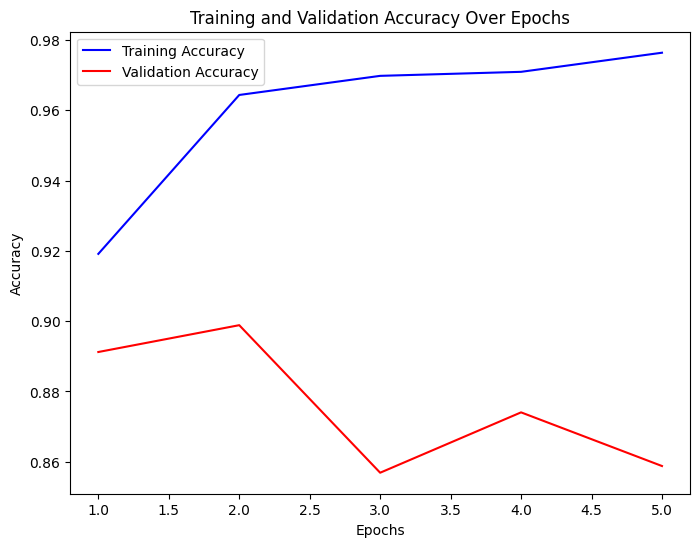

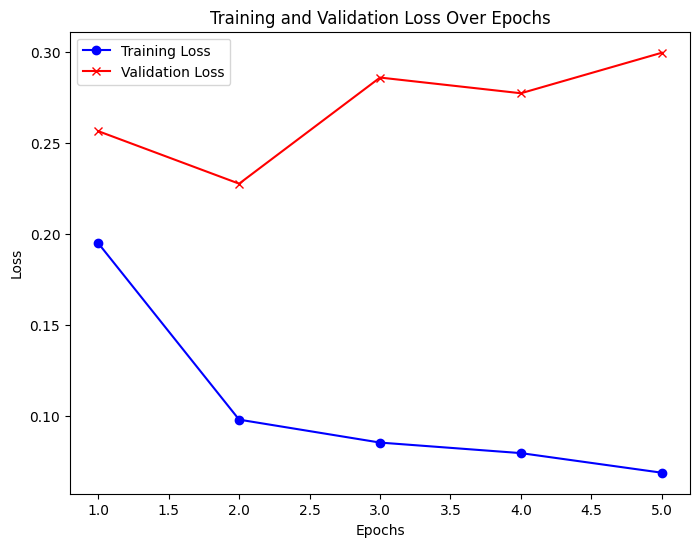

INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


219/219 [==============================] - 1s 3ms/step
y_score shape: (6988, 1)
y_true shape: (6988,)

Classification Report (train set):
              precision    recall  f1-score   support

           0     0.9735    0.9874    0.9804      3494
           1     0.9872    0.9731    0.9801      3494

    accuracy                         0.9803      6988
   macro avg     0.9804    0.9803    0.9803      6988
weighted avg     0.9804    0.9803    0.9803      6988




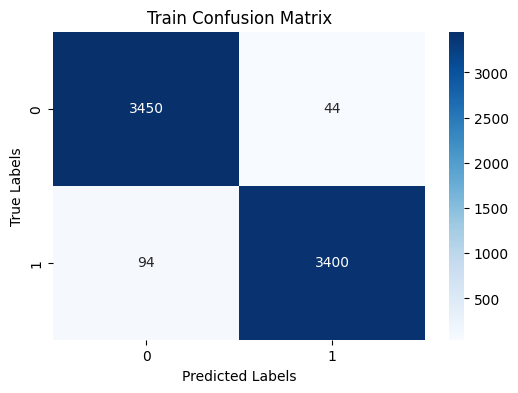

train  AUC: 0.99824, Accuracy: 0.98025

17/17 [==============================] - 0s 3ms/step
y_score shape: (524, 1)
y_true shape: (524,)

Classification Report (val set):
              precision    recall  f1-score   support

           0     0.6473    0.9926    0.7836       135
           1     0.9968    0.8123    0.8952       389

    accuracy                         0.8588       524
   macro avg     0.8221    0.9025    0.8394       524
weighted avg     0.9068    0.8588    0.8664       524




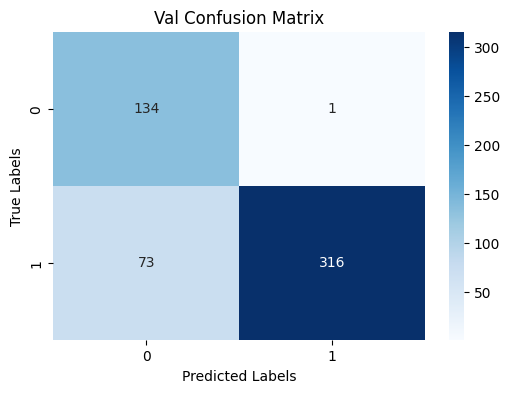

val  AUC: 0.99115, Accuracy: 0.85878

20/20 [==============================] - 0s 3ms/step
y_score shape: (624, 1)
y_true shape: (624,)

Classification Report (test set):
              precision    recall  f1-score   support

           0     0.8455    0.7949    0.8194       234
           1     0.8812    0.9128    0.8967       390

    accuracy                         0.8686       624
   macro avg     0.8633    0.8538    0.8581       624
weighted avg     0.8678    0.8686    0.8677       624




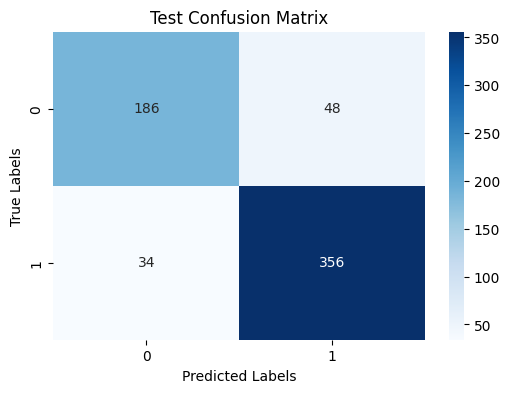

test  AUC: 0.89062, Accuracy: 0.86859



In [ ]:

data_flag = 'pathmnist'
input_root = '/home/wsl/classwork/7015/ass1/MedMNIST/examples/ACGAN_DATA/Merge_ACGAN_data.npz'
run = 'model1'
model_path = None  
num_trials = 2    

main(data_flag, num_trials, input_root, run, model_path)


# AUGMENT

Trial 2 Complete [00h 28m 28s]
val_auc: 0.9735218286514282

Best val_auc So Far: 0.9882128238677979
Total elapsed time: 00h 28m 40s
Epoch 1/5


2025-01-09 19:36:08.078077: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 6988
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2427"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR

219/219 [==============================] - ETA: 0s - loss: 0.1496 - auc: 0.9864 - accuracy: 0.9400

2025-01-09 19:36:10.651654: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_UINT8
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 524
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2432"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 28
        }
        dim {
          size: 28
        }
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR


219/219 [==============================] - 3s 10ms/step - loss: 0.1496 - auc: 0.9864 - accuracy: 0.9400 - val_loss: 0.2911 - val_auc: 0.9557 - val_accuracy: 0.8740
Epoch 2/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0937 - auc: 0.9943 - accuracy: 0.9627 - val_loss: 0.2580 - val_auc: 0.9750 - val_accuracy: 0.8950
Epoch 3/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0856 - auc: 0.9953 - accuracy: 0.9675 - val_loss: 0.2301 - val_auc: 0.9748 - val_accuracy: 0.9065
Epoch 4/5
219/219 [==============================] - 2s 10ms/step - loss: 0.0774 - auc: 0.9960 - accuracy: 0.9717 - val_loss: 0.2225 - val_auc: 0.9800 - val_accuracy: 0.9103
Epoch 5/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0700 - auc: 0.9968 - accuracy: 0.9732 - val_loss: 0.2219 - val_auc: 0.9860 - val_accuracy: 0.9103
INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


INFO:tensorflow:Assets written to: ./pathmnist/best_model/assets


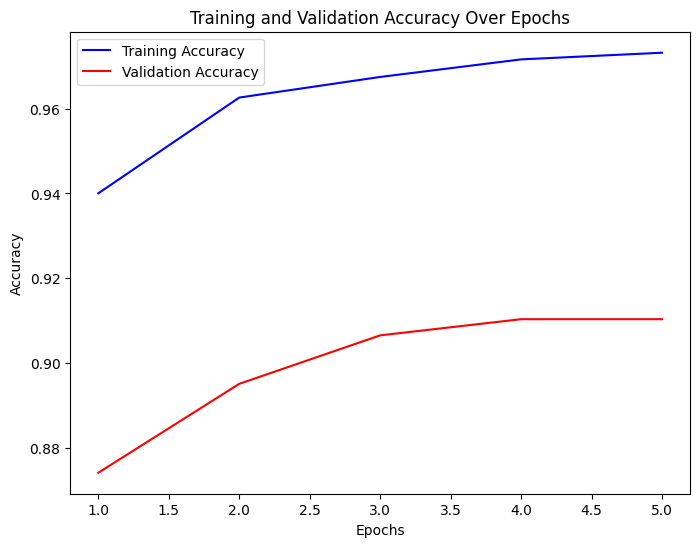

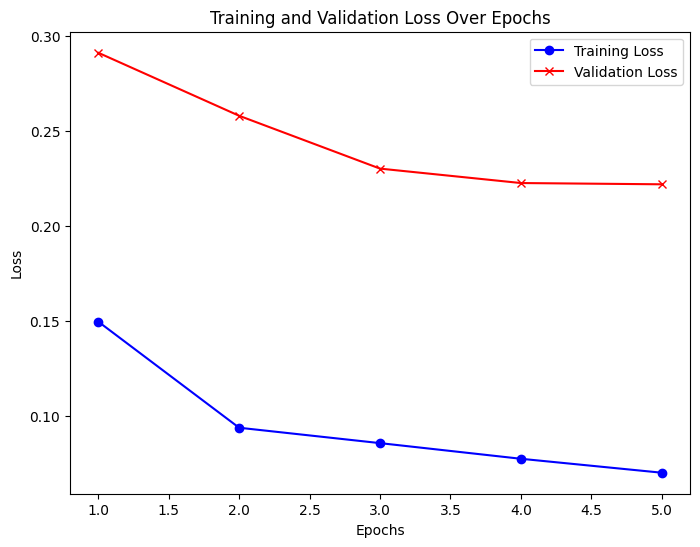

INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


INFO:tensorflow:Assets written to: pathmnist_autokeras/assets


219/219 [==============================] - 1s 3ms/step
y_score shape: (6988, 1)
y_true shape: (6988,)

Classification Report (train set):
              precision    recall  f1-score   support

           0     0.9755    0.9817    0.9786      3494
           1     0.9816    0.9754    0.9785      3494

    accuracy                         0.9785      6988
   macro avg     0.9786    0.9785    0.9785      6988
weighted avg     0.9786    0.9785    0.9785      6988




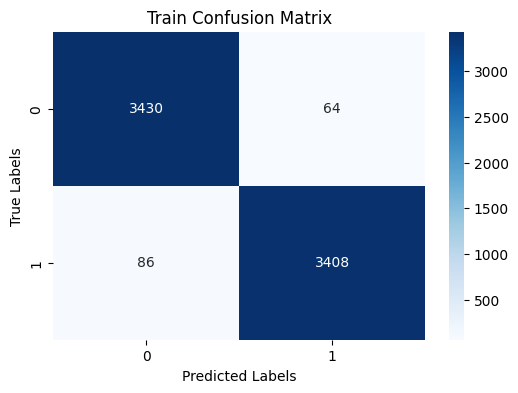

train  AUC: 0.99825, Accuracy: 0.97853

17/17 [==============================] - 0s 3ms/step
y_score shape: (524, 1)
y_true shape: (524,)

Classification Report (val set):
              precision    recall  f1-score   support

           0     0.7529    0.9704    0.8479       135
           1     0.9886    0.8895    0.9364       389

    accuracy                         0.9103       524
   macro avg     0.8707    0.9299    0.8921       524
weighted avg     0.9278    0.9103    0.9136       524




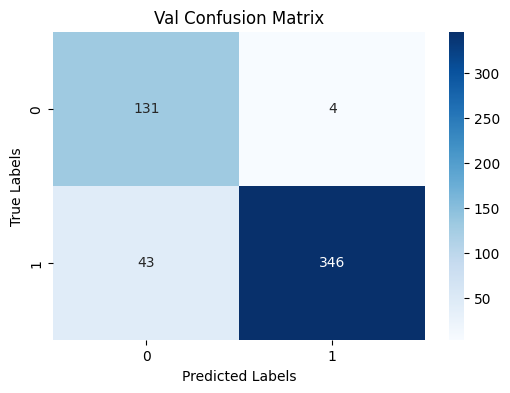

val  AUC: 0.98600, Accuracy: 0.91031

20/20 [==============================] - 0s 3ms/step
y_score shape: (624, 1)
y_true shape: (624,)

Classification Report (test set):
              precision    recall  f1-score   support

           0     0.8446    0.6966    0.7635       234
           1     0.8353    0.9231    0.8770       390

    accuracy                         0.8381       624
   macro avg     0.8399    0.8098    0.8202       624
weighted avg     0.8388    0.8381    0.8344       624




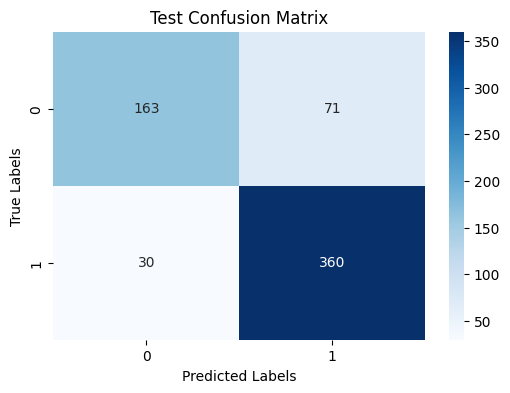

test  AUC: 0.88895, Accuracy: 0.83814



In [29]:

data_flag = 'pathmnist'
input_root = '/home/wsl/classwork/7015/ass1/MedMNIST/examples/DATA_AUGMENT/Merge_data_AUG.npz'
run = 'model1'
model_path = None  
num_trials = 2     

main(data_flag, num_trials, input_root, run, model_path)
